In [18]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import Angle, EarthLocation, AltAz, SkyCoord
from astropy.time import Time
from astropy.visualization import hist

In [3]:
MMT_LOCATION = EarthLocation.from_geodetic("-110:53:04.4", "31:41:19.6", 2600 * u.m)
obstime = Time("2021-08-21T06:00:00", format='isot')

# don't strictly need time or location for our purposes, but astropy wants them for defining the alt/az frame
aa_frame = AltAz(obstime=obstime, location=MMT_LOCATION)

def tpoint(coo, ia, ie, an, aw, ca, npae, tf, tx):
    """
    Apply 8-term alt-az tpoint model to set of raw alt-az coordinates and return corrected coordinates
    """
    da = -1 * ia
    da -= an * np.sin(coo.az) * np.tan(coo.alt)
    da -= aw * np.cos(coo.az) * np.tan(coo.alt)
    da -= ca / np.cos(coo.alt)
    da -= npae * np.tan(coo.alt)

    de = ie
    de -= an * np.cos(coo.az)
    de += aw * np.sin(coo.az)
    de -= tf * np.cos(coo.alt)
    de -= tx / np.tan(coo.alt)

    new_az = coo.az + da * u.arcsec
    new_alt = coo.alt + de * u.arcsec

    new_coo = SkyCoord(new_az, new_alt, frame=aa_frame)
    return new_coo

def skyrms(coo_ref, coo_meas):
    """
    Calculate sky RMS of the offsets between reference and measured coordinates in the same way as tpoint.
    Return the result in arcseconds.
    """
    sep = coo_ref.separation(coo_meas)
    rms = np.sqrt((sep ** 2).mean()).to(u.arcsec)
    return rms

def psd(coo_ref, coo_meas, nterms=8):
    """
    Calculate the population standard deviation, PSD, the way tpoint does. Returh the result in arcseconds. 
    """
    rms = skyrms(coo_ref, coo_meas)
    sd = np.sqrt(rms**2 * len(coo_meas) / (len(coo_meas) - nterms))
    return sd

In [4]:
datafile = "point_tweak.dat"
t = ascii.read(datafile, data_start=20, format='no_header', guess=False, fast_reader=False)
az_obs = Angle(t['col1'], unit=u.degree).wrap_at(360 * u.deg)
el_obs = Angle(t['col2'], unit=u.degree).wrap_at(360 * u.deg)
az_raw = Angle(t['col3'], unit=u.degree).wrap_at(360 * u.deg)
el_raw = Angle(t['col4'], unit=u.degree).wrap_at(360 * u.deg)
coo_obs = SkyCoord(az_obs, el_obs, frame=aa_frame)
coo_raw = SkyCoord(az_raw, el_raw, frame=aa_frame)

In [5]:
coo_obs.separation(coo_raw).std().to(u.arcsec)

<Angle 321.7543166 arcsec>

In [6]:
t_coo = tpoint(coo_raw, 1212.01, -2.99, 2.51, -10.34, -10.10, 0.0, 21.41, -2.71)
seps = coo_obs.separation(t_coo)
np.median(seps.to(u.arcsec))

<Angle 0.73505297 arcsec>

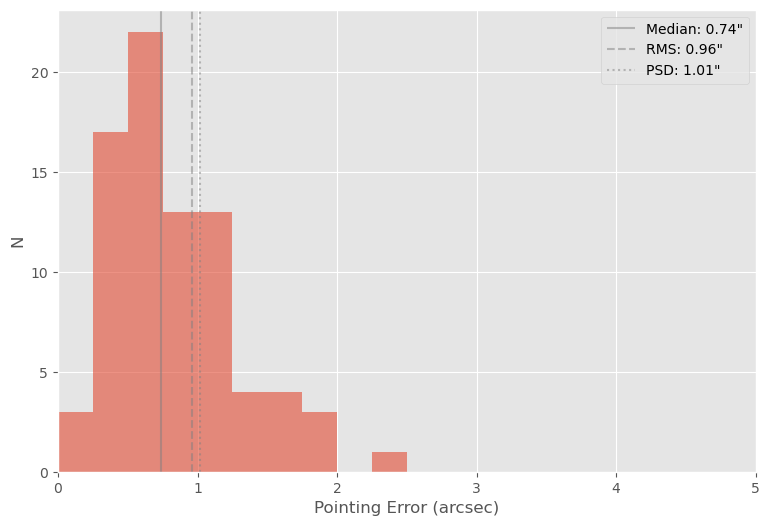

In [48]:
az_res, el_res = coo_obs.spherical_offsets_to(t_coo)
with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
    fig, ax = plt.subplots(figsize=[9, 6])
    bins = np.arange(0, 20)/4  # 0.25" bins
    ax.hist(seps.to(u.arcsec).value, bins=bins, alpha=0.6)
    ax.set_ylabel("N")
    ax.set_xlabel("Pointing Error (arcsec)")
    med = np.median(seps.to(u.arcsec))
    rms = skyrms(coo_obs, t_coo)
    skypsd = psd(coo_obs, t_coo)
    ax.vlines(x=med.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls='-', label=f"Median: {med.value:.2f}\"")
    ax.vlines(x=rms.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls='--', label=f"RMS: {rms.value:.2f}\"")
    ax.vlines(x=skypsd.value, ymin=0, ymax=1, transform=ax.get_xaxis_transform(), color='gray', alpha=0.5, ls=':', label=f"PSD: {skypsd.value:.2f}\"")
    ax.legend()
    ax.set_xlim(0.0, 5.0)
plt.show()

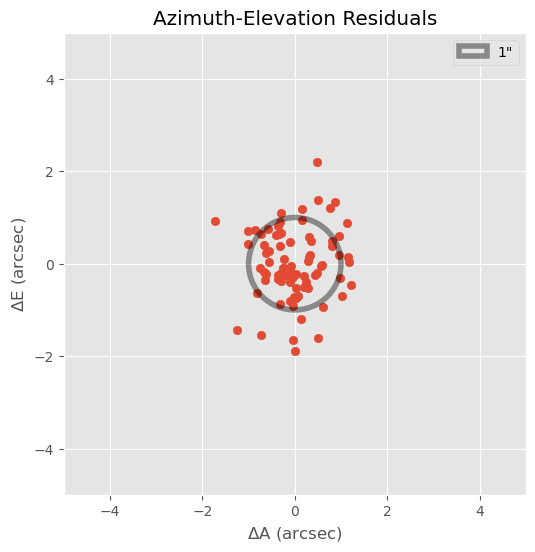

In [119]:
with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
    fig, ax = plt.subplots(figsize=[6, 6])
    ax.set_aspect('equal')
    ax.scatter(az_res.to(u.arcsec), el_res.to(u.arcsec))
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_xlabel("$\Delta$A (arcsec)")
    ax.set_ylabel("$\Delta$E (arcsec)")
    ax.set_title("Azimuth-Elevation Residuals")
    c1 = matplotlib.patches.Circle((0, 0), 1, ec='black', lw=4, fill=False, alpha=0.4, label="1\"")
    ax.add_patch(c1)
    ax.legend()
plt.show()

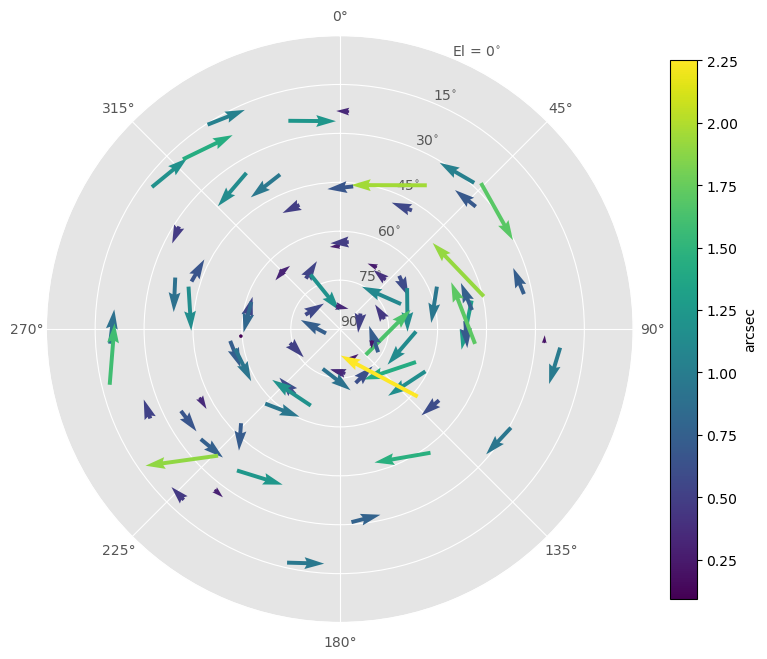

In [137]:
with plt.style.context('ggplot', {'xtick.labelsize': 18, 'ytick.labelsize': 18}):
    x = coo_obs.az
    y = 90 * u.degree - coo_obs.alt  # use zenith angle here as a trick
    uu = (az_res).to(u.arcsec).value
    vv = (-1 * el_res).to(u.arcsec).value
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=[8, 8])
    qq = ax.quiver(
        x.to(u.radian).value, 
        y.value, 
        uu, 
        vv, 
        np.sqrt(uu**2 + vv**2),
        scale_units='y', 
        angles='xy', 
        pivot='tip', 
        color='red'
    )
    #qk = ax.quiverkey(qq, 0.95, 0.95, 1, "1\"", labelpos='W', coordinates='axes', angle=0.0)
    ax.set_rmax(90)
    #ax.set_ylim(90)
    ticks = [0, 15, 30, 45, 60, 75, 90]
    #ticks = [75, 60, 45, 20, 15]
    ax.set_rticks(ticks)
    ax.set_yticklabels([
        "$90^{\circ}$",
        "$75^{\circ}$",
        "$60^{\circ}$",
        "$45^{\circ}$",
        "$30^{\circ}$",
        "$15^{\circ}$",
        "El = $0^{\circ}$",
    ])
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    #ax.scatter([(30 * u.deg).to(u.radian).value], [90], color='b')
    #ax.quiverkey(qq, 0.9, 0.9, 1/3600, "1\"", labelpos='W', coordinates='figure')
cbar = plt.colorbar(qq, shrink=0.7)
cbar.set_label("arcsec")
plt.tight_layout()
plt.show()